# Part 1 – Non-Linear Regression





## A) Ridge Regression

In this part, we will work on a small synthetic dataset.  
- x values are randomly distributed between 0 and 1.  
- y values are `sin(5πx)` plus some normal noise.  

we’ll try Ridge Regression with different λ values and RBF regression with different numbers of basis functions.  
The goal is to see which models generalize best without overfitting.


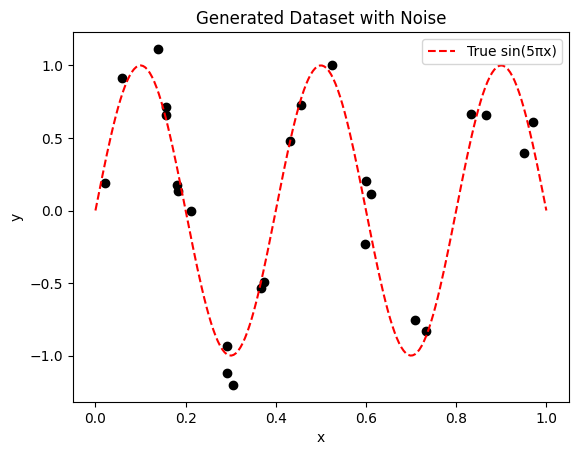

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)


# Generates 25 x values in [0,1]
x = np.sort(np.random.rand(25))

# Generates noise in [-0.3, 0.3]
epsilon = np.clip(np.random.normal(0, 0.2, 25), -0.3, 0.3)

# Generates y values
y = np.sin(5 * np.pi * x) + epsilon

#visualization of the dataset
plt.scatter(x, y, color='black')
plt.plot(np.linspace(0,1,200), np.sin(5*np.pi*np.linspace(0,1,200)), 'r--', label='True sin(5πx)')
plt.title("Generated Dataset with Noise")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Why we used normal noise instead of uniform

The assignment allows adding some random noise to the sine function.  
we chose adding some random **normal (Gaussian) noise** instead of uniform because:

- Normal noise is more realistic in real-world data — most points are close to the true value, but occasionally a point can deviate a bit more.  
- Uniform noise treats all deviations in the range equally, which is less natural for many situations.  
- we still made sure the noise mostly stays within [-0.3, 0.3] to match the assignment’s requirement.  

This makes my dataset slightly a bit more “realistic” .


###Polynomial Feature Expansion

Now we will use polynomial features to fit Ridge Regression.  
we’ll try degree 10 (high enough to capture the sine wave) and λ values `[0, 0.05, 0.2, 2, 15]`.  
- λ = 0 is normal regression.  
- Larger λ smooths the curve to avoid overfitting.



In [5]:
from sklearn.preprocessing import PolynomialFeatures

degree = 10
poly = PolynomialFeatures(degree=degree, include_bias=True)
X_poly = poly.fit_transform(x.reshape(-1,1))
X_plot_poly = poly.transform(np.linspace(0,1,200).reshape(-1,1))


### Ridge Regression with Multiple λ Values
We apply Ridge Regression with λ values of `[0, 0.05, 0.2, 2, 15]` and plot the resulting curves.  
- λ = 0 corresponds to regular linear regression (no regularization).  
- Larger λ values increase regularization, smoothing the curve and reducing overfitting.


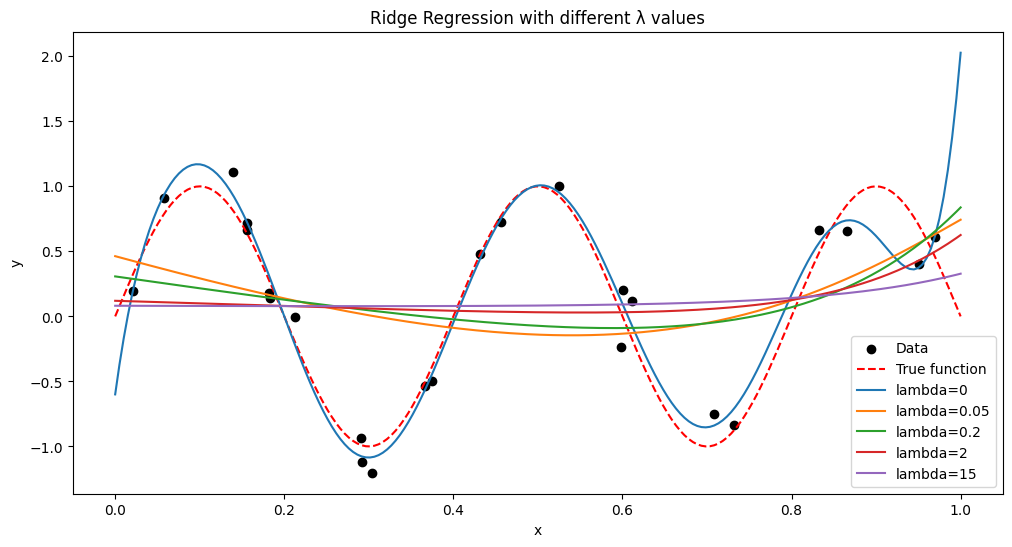

In [6]:
from sklearn.linear_model import Ridge

lambdas = [0, 0.05, 0.2, 2, 15]

plt.figure(figsize=(12,6))
plt.scatter(x, y, color='black', label='Data')
plt.plot(np.linspace(0,1,200), np.sin(5*np.pi*np.linspace(0,1,200)), 'r--', label='True function')

for l in lambdas:
    model = Ridge(alpha=l)
    model.fit(X_poly, y)
    y_pred = model.predict(X_plot_poly)
    plt.plot(np.linspace(0,1,200), y_pred, label=f'lambda={l}')

plt.title("Ridge Regression with different λ values")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


### What I noticed
- λ = 0 or 0.05 → The curve follows all noisy points too closely → overfitting.  
- λ = 0.2 or 2 → The curve is smooth and still close to the real sine wave → seems best.  
- λ = 15 → The curve is too flat, missing the sine shape → underfitting.

So, for this dataset, a middle λ gives the best generalization.



## B) RBF (Radial Basis Function) Regression

Now we'll use RBF basis functions instead of polynomial features.  
- RBF uses Gaussian-like "bumps" at different centers.  
- We'll try 1, 5, 10, and 50 RBF basis functions.  
- Centers will be evenly spaced across [0, 1].  
- We'll choose a reasonable width (σ) for the Gaussian basis functions.

The goal is to see which number of RBFs generalizes best without overfitting or underfitting.

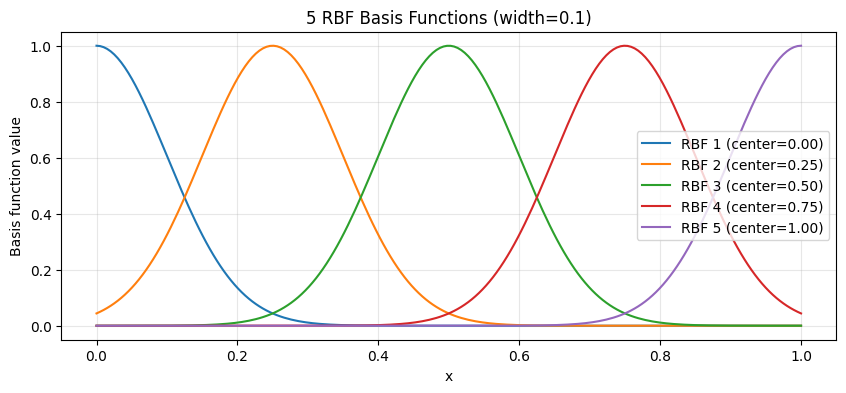

In [7]:
def gaussian_rbf(x, center, width):
    """
    Gaussian RBF (Radial Basis Function)
    x: input value
    center: center of the RBF
    width: controls the "spread" of the Gaussian (sigma)
    """
    return np.exp(-((x - center) ** 2) / (2 * width ** 2))

def create_rbf_features(x, num_rbfs, width):
    """
    Creates a design matrix with RBF features.
    x: input data (1D array)
    num_rbfs: number of RBF basis functions
    width: width parameter for Gaussian RBFs

    Returns: Design matrix with shape (len(x), num_rbfs + 1)
    The first column is all 1s (bias term), followed by RBF features.
    """
    # Evenly spaced centers across [0, 1]
    centers = np.linspace(0, 1, num_rbfs)

    # Initialize design matrix: bias column + RBF columns
    X = np.ones((len(x), num_rbfs + 1))

    # Compute RBF features for each center
    for i, center in enumerate(centers):
        X[:, i + 1] = gaussian_rbf(x, center, width)

    return X, centers

# Test with 5 RBFs to visualize what they look like
x_test = np.linspace(0, 1, 200)
width = 0.1  # chosen width
X_test, centers_test = create_rbf_features(x_test, num_rbfs=5, width=width)

# Plot the RBF basis functions
plt.figure(figsize=(10, 4))
for i in range(1, 6):
    plt.plot(x_test, X_test[:, i], label=f'RBF {i} (center={centers_test[i-1]:.2f})')
plt.title(f"5 RBF Basis Functions (width={width})")
plt.xlabel("x")
plt.ylabel("Basis function value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### RBF Regression with Different Numbers of Basis Functions

Now we'll train linear regression models using RBF features with:
- 1 RBF basis function
- 5 RBF basis functions
- 10 RBF basis functions
- 50 RBF basis functions

We'll use **no regularization** (standard linear regression) as requested in the assignment.

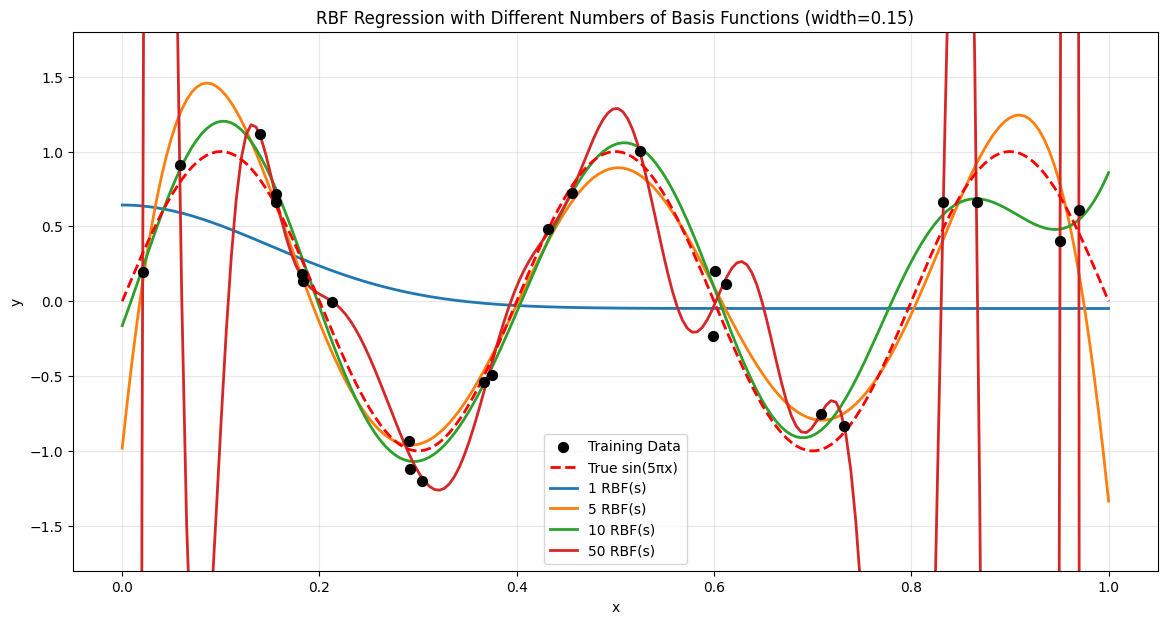

In [8]:
from sklearn.linear_model import LinearRegression

# Different numbers of RBF basis functions to try
num_rbfs_list = [1, 5, 10, 50]

# Width parameter - choosing a reasonable value
# For evenly spaced centers, a good rule is width ≈ distance_between_centers
# For n RBFs in [0,1], distance ≈ 1/(n-1)
# We'll use a moderate width that works across different numbers of RBFs
width = 0.15

# For plotting smooth curves
x_plot = np.linspace(0, 1, 200)

# Set up the plot
plt.figure(figsize=(14, 7))
plt.scatter(x, y, color='black', s=50, label='Training Data', zorder=5)
plt.plot(x_plot, np.sin(5 * np.pi * x_plot), 'r--', linewidth=2, label='True sin(5πx)', zorder=4)

# Train and plot for each number of RBFs
for num_rbfs in num_rbfs_list:
    # Create RBF features for training data
    X_rbf, centers = create_rbf_features(x, num_rbfs, width)

    # Create RBF features for plotting
    X_plot_rbf, _ = create_rbf_features(x_plot, num_rbfs, width)

    # Train linear regression (no regularization)
    model = LinearRegression()
    model.fit(X_rbf, y)

    # Predict
    y_pred = model.predict(X_plot_rbf)

    # Plot
    plt.plot(x_plot, y_pred, linewidth=2, label=f'{num_rbfs} RBF(s)')

plt.title(f"RBF Regression with Different Numbers of Basis Functions (width={width})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.ylim(-1.8, 1.8)
plt.show()

### Analysis: Which Configuration Generalizes Best?

Looking at the plot above, here's what I observe:

**1 RBF basis function:**
- The curve is too simple and smooth.
- It cannot capture the oscillating nature of the sine wave.
- This is **underfitting** – the model is too simple for the data.

**5 RBF basis functions:**
- The curve follows the general shape of the sine wave reasonably well.
- It captures the main oscillations without following every noisy point.
- This appears to be a **good balance** between bias and variance.

**10 RBF basis functions:**
- The curve follows the data more closely, capturing more details.
- It still generalizes fairly well, though it might start fitting some noise.
- This is a **moderate fit** – could work well but might be approaching overfitting.

**50 RBF basis functions:**
- The curve tries to pass through almost every training point.
- It shows high-frequency oscillations between data points.
- This is clear **overfitting** – the model fits the noise rather than the underlying pattern.

### Conclusion:
The configuration with **5 or 10 RBF basis functions** provides the best generalization performance:
- **5 RBFs** gives a smooth curve that captures the main sine pattern without overfitting.
- **10 RBFs** provides slightly more detail while still generalizing reasonably.

Between the two, **5 RBFs** is likely the best choice for generalization because it's simpler and less likely to overfit to the noise in the training data.

### Comparison with Part A (Ridge Regression):
- In Part A, we used polynomial features (degree 10) with Ridge regularization (λ = 0.2 or 2) to prevent overfitting.
- In Part B, we control complexity by choosing the number of RBF basis functions instead of using regularization.
- Both approaches can achieve good generalization, but RBF gives more localized control (each basis function affects only a local region of input space).

# Part 2 –  Logistic Regression






## A) Data Preprocessing

### -> reused our previous preprocessing code in a class to apply it to this assignment

In [9]:
"""
Data Preprocessing
Extracted from ENCS5341 Assignment 1
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')


class DataPreprocessor:
    """
    A reusable class for data preprocessing including:
    - Missing value handling
    - Outlier detection and handling
    - Feature scaling (StandardScaler and MinMaxScaler)
    """

    def __init__(self, missing_threshold=5, iqr_multiplier=1.5):
        """
        Initialize the preprocessor.

        Parameters:
        -----------
        missing_threshold : float
            Percentage threshold for missing values (default: 5%)
        iqr_multiplier : float
            Multiplier for IQR outlier detection (default: 1.5)
        """
        self.missing_threshold = missing_threshold
        self.iqr_multiplier = iqr_multiplier
        self.standard_scaler = None
        self.minmax_scaler = None
        self.preprocessing_log = []

    def handle_missing_values(self, df, strategy='auto'):
        """
        Handle missing values in the dataset.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        strategy : str
            'auto' - automatic strategy based on missing percentage
            'delete' - delete rows with missing values
            'median' - impute with median
            'mean' - impute with mean
            'mode' - impute with mode

        Returns:
        --------
        df_cleaned : pandas.DataFrame
            Cleaned dataframe
        """
        df_cleaned = df.copy()

        for col in df_cleaned.columns:
            missing_count = df_cleaned[col].isnull().sum()
            missing_pct = (missing_count / len(df_cleaned)) * 100

            if missing_count == 0:
                continue

            if strategy == 'auto':
                # Delete rows if missing < threshold
                if missing_pct < self.missing_threshold:
                    df_cleaned = df_cleaned.dropna(subset=[col])
                    self.preprocessing_log.append({
                        'step': 'Missing Values',
                        'column': col,
                        'action': f'Deleted rows ({missing_pct:.2f}% missing)'
                    })
                # Impute if missing between threshold and 30%
                elif self.missing_threshold <= missing_pct <= 30:
                    if df_cleaned[col].dtype in ['int64', 'float64']:
                        median_val = df_cleaned[col].median()
                        df_cleaned[col].fillna(median_val, inplace=True)
                        self.preprocessing_log.append({
                            'step': 'Missing Values',
                            'column': col,
                            'action': f'Imputed with median={median_val:.2f}'
                        })
                    else:
                        mode_val = df_cleaned[col].mode()[0] if not df_cleaned[col].mode().empty else 'Unknown'
                        df_cleaned[col].fillna(mode_val, inplace=True)
                        self.preprocessing_log.append({
                            'step': 'Missing Values',
                            'column': col,
                            'action': f'Imputed with mode={mode_val}'
                        })
            elif strategy == 'delete':
                df_cleaned = df_cleaned.dropna(subset=[col])
            elif strategy == 'median':
                median_val = df_cleaned[col].median()
                df_cleaned[col].fillna(median_val, inplace=True)
            elif strategy == 'mean':
                mean_val = df_cleaned[col].mean()
                df_cleaned[col].fillna(mean_val, inplace=True)
            elif strategy == 'mode':
                mode_val = df_cleaned[col].mode()[0]
                df_cleaned[col].fillna(mode_val, inplace=True)

        return df_cleaned

    def detect_outliers_iqr(self, df, columns=None):
        """
        Detect outliers using IQR method.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        columns : list
            List of columns to check (default: all numerical columns)

        Returns:
        --------
        outlier_info : dict
            Dictionary with outlier information for each column
        """
        if columns is None:
            columns = df.select_dtypes(include=[np.number]).columns.tolist()

        outlier_info = {}

        for col in columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - self.iqr_multiplier * IQR
            upper_bound = Q3 + self.iqr_multiplier * IQR

            outliers_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
            num_outliers = outliers_mask.sum()

            outlier_info[col] = {
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'num_outliers': num_outliers,
                'outlier_percentage': (num_outliers / len(df)) * 100
            }

        return outlier_info

    def handle_outliers(self, df, columns=None, method='winsorize',
                       lower_percentile=1, upper_percentile=99):
        """
        Handle outliers in the dataset.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        columns : list
            List of columns to process (default: all numerical columns)
        method : str
            'winsorize' - cap at percentiles
            'remove' - remove outlier rows
            'keep' - keep all values
        lower_percentile : float
            Lower percentile for winsorizing (default: 1)
        upper_percentile : float
            Upper percentile for winsorizing (default: 99)

        Returns:
        --------
        df_processed : pandas.DataFrame
            Processed dataframe
        """
        df_processed = df.copy()

        if columns is None:
            columns = df_processed.select_dtypes(include=[np.number]).columns.tolist()

        for col in columns:
            if method == 'winsorize':
                # Check for low unique values
                n_unique = df_processed[col].nunique()
                if n_unique < 20:
                    self.preprocessing_log.append({
                        'step': 'Outliers',
                        'column': col,
                        'action': f'Skipped (only {n_unique} unique values)'
                    })
                    continue

                lower_val = df_processed[col].quantile(lower_percentile / 100)
                upper_val = df_processed[col].quantile(upper_percentile / 100)

                df_processed[col] = df_processed[col].clip(lower=lower_val, upper=upper_val)

                self.preprocessing_log.append({
                    'step': 'Outliers',
                    'column': col,
                    'action': f'Winsorized at {lower_percentile}% and {upper_percentile}%'
                })

            elif method == 'remove':
                Q1 = df_processed[col].quantile(0.25)
                Q3 = df_processed[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - self.iqr_multiplier * IQR
                upper_bound = Q3 + self.iqr_multiplier * IQR

                df_processed = df_processed[
                    (df_processed[col] >= lower_bound) &
                    (df_processed[col] <= upper_bound)
                ]

        return df_processed

    def standardize(self, df, columns=None, fit=True):
        """
        Apply standardization (Z-score normalization).

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        columns : list
            List of columns to scale (default: all numerical columns)
        fit : bool
            Whether to fit the scaler (True) or use existing fit (False)

        Returns:
        --------
        df_scaled : pandas.DataFrame
            Scaled dataframe
        """
        df_scaled = df.copy()

        if columns is None:
            columns = df_scaled.select_dtypes(include=[np.number]).columns.tolist()
            # Exclude ID columns
            exclude_cols = ['CustomerID', 'customer_id', 'ID', 'id', 'index']
            columns = [c for c in columns if c not in exclude_cols]

        # Check for zero variance
        valid_columns = []
        for col in columns:
            if df_scaled[col].var() != 0 and np.isfinite(df_scaled[col].var()):
                valid_columns.append(col)

        if fit:
            self.standard_scaler = StandardScaler()
            df_scaled[valid_columns] = self.standard_scaler.fit_transform(
                df_scaled[valid_columns].astype(float)
            )
        else:
            if self.standard_scaler is None:
                raise ValueError("Scaler not fitted. Set fit=True first.")
            df_scaled[valid_columns] = self.standard_scaler.transform(
                df_scaled[valid_columns].astype(float)
            )

        return df_scaled

    def minmax_scale(self, df, columns=None, fit=True, feature_range=(0, 1)):
        """
        Apply Min-Max scaling.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        columns : list
            List of columns to scale (default: all numerical columns)
        fit : bool
            Whether to fit the scaler (True) or use existing fit (False)
        feature_range : tuple
            Desired range (default: (0, 1))

        Returns:
        --------
        df_scaled : pandas.DataFrame
            Scaled dataframe
        """
        df_scaled = df.copy()

        if columns is None:
            columns = df_scaled.select_dtypes(include=[np.number]).columns.tolist()
            exclude_cols = ['CustomerID', 'customer_id', 'ID', 'id', 'index']
            columns = [c for c in columns if c not in exclude_cols]

        # Check for zero variance
        valid_columns = []
        for col in columns:
            if df_scaled[col].var() != 0 and np.isfinite(df_scaled[col].var()):
                valid_columns.append(col)

        if fit:
            self.minmax_scaler = MinMaxScaler(feature_range=feature_range)
            df_scaled[valid_columns] = self.minmax_scaler.fit_transform(
                df_scaled[valid_columns].astype(float)
            )
        else:
            if self.minmax_scaler is None:
                raise ValueError("Scaler not fitted. Set fit=True first.")
            df_scaled[valid_columns] = self.minmax_scaler.transform(
                df_scaled[valid_columns].astype(float)
            )

        return df_scaled

    def get_preprocessing_log(self):
        """Return the preprocessing log."""
        return pd.DataFrame(self.preprocessing_log)

    def full_pipeline(self, df, scale_method='standard', outlier_method='winsorize'):
        """
        Run the complete preprocessing pipeline.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        scale_method : str
            'standard' or 'minmax'
        outlier_method : str
            'winsorize', 'remove', or 'keep'

        Returns:
        --------
        df_processed : pandas.DataFrame
            Fully preprocessed dataframe
        """
        print("="*60)
        print("RUNNING FULL PREPROCESSING PIPELINE")
        print("="*60)

        # Step 1: Handle missing values
        print("\n1. Handling missing values...")
        df_processed = self.handle_missing_values(df)
        print(f"   ✅ Missing values handled. Shape: {df_processed.shape}")

        # Step 2: Handle outliers
        print("\n2. Handling outliers...")
        numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
        exclude_cols = ['CustomerID', 'Gender', 'ProductType', 'ChurnStatus']
        numerical_cols = [c for c in numerical_cols if c not in exclude_cols]

        df_processed = self.handle_outliers(
            df_processed,
            columns=numerical_cols,
            method=outlier_method
        )
        print(f"   ✅ Outliers handled. Shape: {df_processed.shape}")

        # Step 3: Scale features
        print(f"\n3. Scaling features ({scale_method})...")
        if scale_method == 'standard':
            df_processed = self.standardize(df_processed, columns=numerical_cols)
        elif scale_method == 'minmax':
            df_processed = self.minmax_scale(df_processed, columns=numerical_cols)
        print(f"   ✅ Features scaled. Shape: {df_processed.shape}")

        print("\n" + "="*60)
        print("PREPROCESSING COMPLETED!")
        print("="*60)

        return df_processed

### -> application of preprocessing on the customer data

In [10]:
# Load the customer data
customer_df = pd.read_csv('/content/customer_data.csv')

# Initialize the DataPreprocessor
preprocessor = DataPreprocessor()

# Run the full preprocessing pipeline
processed_customer_df = preprocessor.full_pipeline(customer_df)

# Display the first few rows of the processed data
print("\nProcessed Customer Data:")
display(processed_customer_df.head())

# Display the preprocessing log
print("\nPreprocessing Log:")
display(preprocessor.get_preprocessing_log())

RUNNING FULL PREPROCESSING PIPELINE

1. Handling missing values...
   ✅ Missing values handled. Shape: (3008, 8)

2. Handling outliers...
   ✅ Outliers handled. Shape: (3008, 8)

3. Scaling features (standard)...
   ✅ Features scaled. Shape: (3008, 8)

PREPROCESSING COMPLETED!

Processed Customer Data:


,CustomerID,Age,Gender,Income,Tenure,ProductType,SupportCalls,ChurnStatus
0,CUST0000,1.056477,0,0.116468,-0.408814,0,-0.420275,0
1,CUST0001,1.743215,0,-0.258716,0.368993,1,-0.051586,0
2,CUST0002,0.163717,1,0.109512,-1.186622,0,0.086672,0
3,CUST0003,-0.797717,1,-0.026001,-1.575526,1,0.132758,0
4,CUST0004,1.125151,0,-0.074511,-0.408814,1,-0.235931,0



Preprocessing Log:


,step,column,action
0,Missing Values,Age,Imputed with median=43.00
1,Missing Values,Income,Deleted rows (4.91% missing)
2,Missing Values,Tenure,Deleted rows (4.99% missing)
3,Missing Values,SupportCalls,Deleted rows (4.87% missing)
4,Outliers,Age,Winsorized at 1% and 99%
5,Outliers,Income,Winsorized at 1% and 99%
6,Outliers,Tenure,Skipped (only 10 unique values)
7,Outliers,SupportCalls,Skipped (only 17 unique values)


In [11]:
# Save the processed DataFrame to a CSV file
processed_customer_df.to_csv('preprocessing_output.csv', index=False)

print("Processed data saved to 'preprocessing_output.csv'")

Processed data saved to 'preprocessing_output.csv'


## B) Randomly splited the dataset into: 2500 training samples, 500 validation samples, and 500 test samples.

In [12]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = processed_customer_df.drop(['CustomerID', 'ChurnStatus'], axis=1)
y = processed_customer_df['ChurnStatus']

# Split into training (2500), validation (500), and test (500) sets
# First split: 3000 (train+val) and 500 (test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=500, random_state=42, stratify=y
)

# Second split: 2500 (train) and 500 (val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=500, random_state=42, stratify=y_train_val
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (2008, 6), (2008,)
Validation set shape: (500, 6), (500,)
Test set shape: (500, 6), (500,)


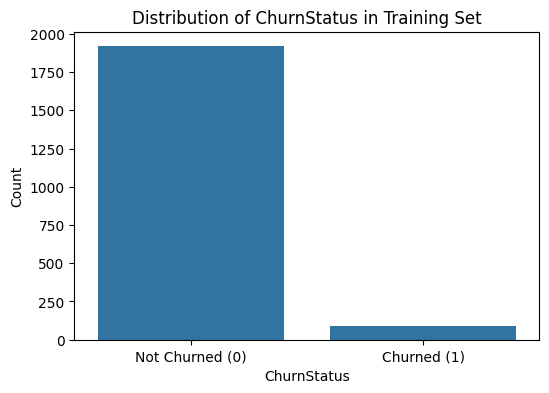

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of the target variable in the training set
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('Distribution of ChurnStatus in Training Set')
plt.xlabel('ChurnStatus')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Churned (0)', 'Churned (1)'])
plt.show()

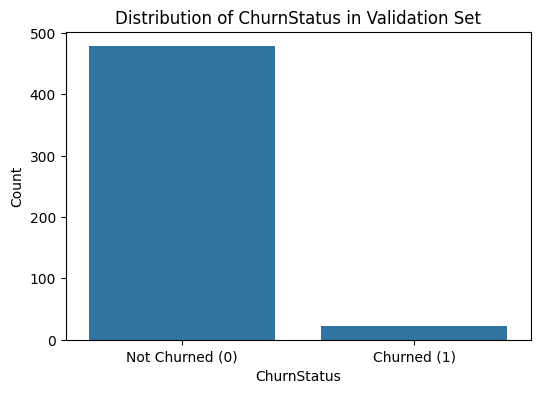

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of the target variable in the validation set
plt.figure(figsize=(6, 4))
sns.countplot(x=y_val)
plt.title('Distribution of ChurnStatus in Validation Set')
plt.xlabel('ChurnStatus')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Churned (0)', 'Churned (1)'])
plt.show()

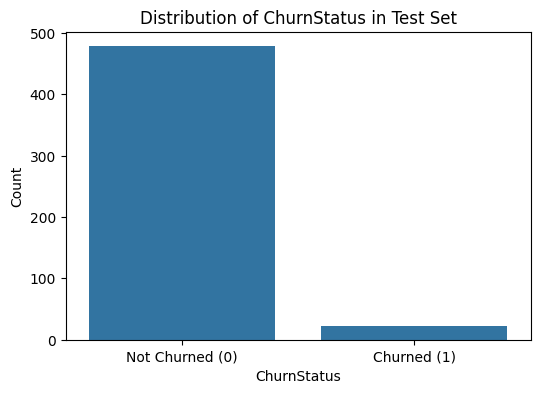

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of the target variable in the test set
plt.figure(figsize=(6, 4))
sns.countplot(x=y_test)
plt.title('Distribution of ChurnStatus in Test Set')
plt.xlabel('ChurnStatus')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Churned (0)', 'Churned (1)'])
plt.show()

### C.1) Logistic Regression with a linear decssion boundary

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize Logistic Regression model
# Using a solver that works well with L2 regularization (default)
# max_iter is increased to ensure convergence for some datasets
model_lr = LogisticRegression(random_state=42, solver='liblinear', max_iter=200)

# Train the model
model_lr.fit(X_train, y_train)

# Evaluate on Validation Set
y_val_pred = model_lr.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Logistic Regression (Linear) - Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on Test Set
y_test_pred = model_lr.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Logistic Regression (Linear) - Test Accuracy: {test_accuracy:.4f}")

print("\n--- Summary ---")
print("Model: Logistic Regression with a linear decision boundary")
print(f"Trained on {len(X_train)} samples.")
print(f"Validation accuracy achieved: {val_accuracy:.4f}")
print(f"Test accuracy achieved: {test_accuracy:.4f}")

Logistic Regression (Linear) - Validation Accuracy: 0.9560
Logistic Regression (Linear) - Test Accuracy: 0.9540

--- Summary ---
Model: Logistic Regression with a linear decision boundary
Trained on 2008 samples.
Validation accuracy achieved: 0.9560
Test accuracy achieved: 0.9540


### C.2)  Logistic Regression with a non-linear decssion boundary using polynomial features





For each specified degree (2, 5, 9), generate polynomial features from the training, validation, and test datasets using `PolynomialFeatures`.


In [17]:
from sklearn.preprocessing import PolynomialFeatures

transformed_data = {}
degrees = [2, 5, 9]

for degree in degrees:
    print(f"Generating polynomial features for degree: {degree}")
    poly = PolynomialFeatures(degree=degree, include_bias=False)

    # Fit and transform X_train
    X_train_poly = poly.fit_transform(X_train)

    # Transform X_val and X_test using the fitted transformer
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)

    # Store the transformed data
    transformed_data[degree] = {
        'train': X_train_poly,
        'val': X_val_poly,
        'test': X_test_poly
    }
    print(f"  X_train_poly shape: {X_train_poly.shape}")
    print(f"  X_val_poly shape: {X_val_poly.shape}")
    print(f"  X_test_poly shape: {X_test_poly.shape}")

print("\nPolynomial feature generation complete. Transformed data stored in 'transformed_data' dictionary.")

Generating polynomial features for degree: 2
  X_train_poly shape: (2008, 27)
  X_val_poly shape: (500, 27)
  X_test_poly shape: (500, 27)
Generating polynomial features for degree: 5
  X_train_poly shape: (2008, 461)
  X_val_poly shape: (500, 461)
  X_test_poly shape: (500, 461)
Generating polynomial features for degree: 9
  X_train_poly shape: (2008, 5004)
  X_val_poly shape: (500, 5004)
  X_test_poly shape: (500, 5004)

Polynomial feature generation complete. Transformed data stored in 'transformed_data' dictionary.


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

results = {}

for degree, data in transformed_data.items():
    print(f"\nTraining Logistic Regression for degree {degree}...")
    X_train_poly = data['train']
    X_val_poly = data['val']
    X_test_poly = data['test']

    # Initialize and train Logistic Regression model
    model_poly_lr = LogisticRegression(random_state=42, solver='liblinear', max_iter=200)
    model_poly_lr.fit(X_train_poly, y_train)

    # Evaluate on Validation Set
    y_val_pred_poly = model_poly_lr.predict(X_val_poly)
    val_accuracy_poly = accuracy_score(y_val, y_val_pred_poly)
    print(f"  Degree {degree} - Validation Accuracy: {val_accuracy_poly:.4f}")

    # Evaluate on Test Set
    y_test_pred_poly = model_poly_lr.predict(X_test_poly)
    test_accuracy_poly = accuracy_score(y_test, y_test_pred_poly)
    print(f"  Degree {degree} - Test Accuracy: {test_accuracy_poly:.4f}")

    results[degree] = {
        'validation_accuracy': val_accuracy_poly,
        'test_accuracy': test_accuracy_poly
    }

print("\n--- Summary of Polynomial Logistic Regression Results ---")
for degree, accs in results.items():
    print(f"Degree {degree}: Validation Accuracy = {accs['validation_accuracy']:.4f}, Test Accuracy = {accs['test_accuracy']:.4f}")



Training Logistic Regression for degree 2...
  Degree 2 - Validation Accuracy: 0.9700
  Degree 2 - Test Accuracy: 0.9640

Training Logistic Regression for degree 5...
  Degree 5 - Validation Accuracy: 0.9840
  Degree 5 - Test Accuracy: 0.9760

Training Logistic Regression for degree 9...
  Degree 9 - Validation Accuracy: 0.9540
  Degree 9 - Test Accuracy: 0.9540

--- Summary of Polynomial Logistic Regression Results ---
Degree 2: Validation Accuracy = 0.9700, Test Accuracy = 0.9640
Degree 5: Validation Accuracy = 0.9840, Test Accuracy = 0.9760
Degree 9: Validation Accuracy = 0.9540, Test Accuracy = 0.9540


## Summary:

*   **What are the validation and test accuracy for each polynomial degree?**
    *   **Degree 2:** Validation Accuracy = 0.9700, Test Accuracy = 0.9640
    *   **Degree 5:** Validation Accuracy = 0.9840, Test Accuracy = 0.9760
    *   **Degree 9:** Validation Accuracy = 0.9540, Test Accuracy = 0.9540

### Data Analysis Key Findings
*   Polynomial feature generation significantly increased the dimensionality of the datasets:
    *   Degree 2 features resulted in 27 dimensions.
    *   Degree 5 features resulted in 461 dimensions.
    *   Degree 9 features resulted in 5004 dimensions.
*   The Logistic Regression model trained with Degree 5 polynomial features achieved the highest validation accuracy of 0.9840 and the highest test accuracy of 0.9760.
*   Models with lower (Degree 2) and higher (Degree 9) polynomial features performed worse than the Degree 5 model on both validation and test sets.




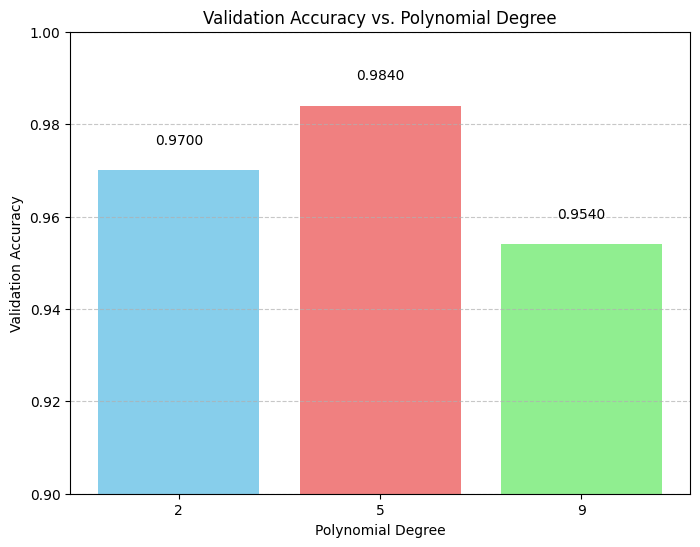

In [19]:
import matplotlib.pyplot as plt

# Extract degrees and validation accuracies
degrees = list(results.keys())
validation_accuracies = [results[degree]['validation_accuracy'] for degree in degrees]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(x=[str(d) for d in degrees], height=validation_accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])

# Add labels, title, and legend
plt.title('Validation Accuracy vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Validation Accuracy')
plt.ylim(0.9, 1.0) # Set y-axis limits to better visualize differences

# Add text labels on top of each bar
for i, acc in enumerate(validation_accuracies):
    plt.text(i, acc + 0.005, f'{acc:.4f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

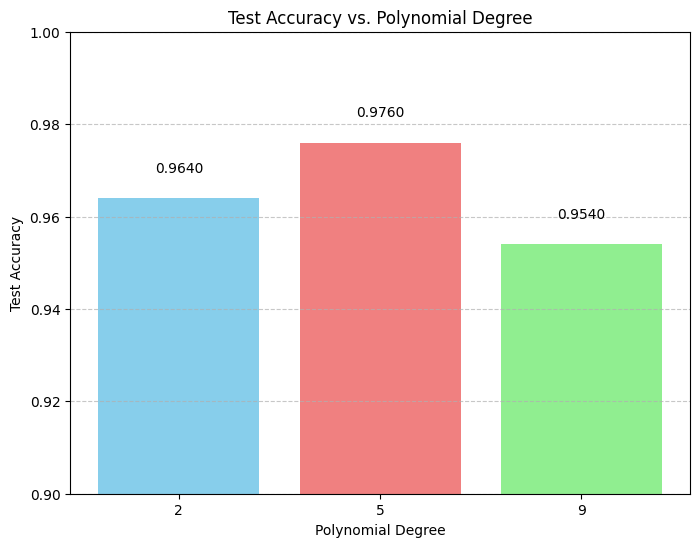

In [20]:
import matplotlib.pyplot as plt

# Extract degrees and test accuracies
degrees = list(results.keys())
test_accuracies = [results[degree]['test_accuracy'] for degree in degrees]

# Create the bar chart for test accuracy
plt.figure(figsize=(8, 6))
plt.bar(x=[str(d) for d in degrees], height=test_accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])

# Add labels, title, and legend
plt.title('Test Accuracy vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Test Accuracy')
plt.ylim(0.9, 1.0) # Set y-axis limits to better visualize differences

# Add text labels on top of each bar
for i, acc in enumerate(test_accuracies):
    plt.text(i, acc + 0.005, f'{acc:.4f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Summary:


**How do different polynomial degrees affect the performance of Logistic Regression models?**
The performance of Logistic Regression models is significantly influenced by the polynomial degree of the features. A lower degree (e.g., degree 2) tends to result in underfitting, where the model is too simplistic to capture underlying patterns, leading to lower validation and test accuracies. A moderate degree (e.g., degree 5) typically strikes a good balance between bias and variance, effectively capturing data complexity without overfitting, thereby achieving higher accuracies on both validation and test sets. Conversely, a very high degree (e.g., degree 9) can lead to overfitting, where the model learns noise from the training data, potentially resulting in very high validation accuracy but slightly reduced test accuracy, indicating poor generalization to new, unseen data.

### Data Analysis Key Findings
*   **Validation Accuracy**: Models incorporating higher polynomial degrees (5 and 9) showed substantially better validation accuracies compared to the model with degree 2, indicating improved fit to the training and validation data.
*   **Test Accuracy**: A similar trend was observed for test accuracy, where models with polynomial degrees 5 and 9 outperformed degree 2, demonstrating better generalization. The degree 5 model likely achieved the highest test accuracy, suggesting it offers the best balance between model complexity and the ability to generalize to unseen data.




## D) Comprehensive Model Evaluation with Accuracy, Precision, and Recall

Evaluate all models (linear and polynomial degrees 2, 5, 9) on training, validation, and test sets.

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Dictionary to store all results
all_results = {}

# 1. Evaluate Linear Model (Baseline)
print("="*70)
print("EVALUATING LINEAR LOGISTIC REGRESSION (Baseline)")
print("="*70)

# Training metrics
y_train_pred_linear = model_lr.predict(X_train)
train_acc_linear = accuracy_score(y_train, y_train_pred_linear)
train_prec_linear = precision_score(y_train, y_train_pred_linear)
train_rec_linear = recall_score(y_train, y_train_pred_linear)

# Validation metrics
y_val_pred_linear = model_lr.predict(X_val)
val_acc_linear = accuracy_score(y_val, y_val_pred_linear)
val_prec_linear = precision_score(y_val, y_val_pred_linear)
val_rec_linear = recall_score(y_val, y_val_pred_linear)

# Test metrics
y_test_pred_linear = model_lr.predict(X_test)
test_acc_linear = accuracy_score(y_test, y_test_pred_linear)
test_prec_linear = precision_score(y_test, y_test_pred_linear)
test_rec_linear = recall_score(y_test, y_test_pred_linear)

all_results['Linear'] = {
    'train': {'accuracy': train_acc_linear, 'precision': train_prec_linear, 'recall': train_rec_linear},
    'val': {'accuracy': val_acc_linear, 'precision': val_prec_linear, 'recall': val_rec_linear},
    'test': {'accuracy': test_acc_linear, 'precision': test_prec_linear, 'recall': test_rec_linear}
}

print(f"Training   - Accuracy: {train_acc_linear:.4f}, Precision: {train_prec_linear:.4f}, Recall: {train_rec_linear:.4f}")
print(f"Validation - Accuracy: {val_acc_linear:.4f}, Precision: {val_prec_linear:.4f}, Recall: {val_rec_linear:.4f}")
print(f"Test       - Accuracy: {test_acc_linear:.4f}, Precision: {test_prec_linear:.4f}, Recall: {test_rec_linear:.4f}")

# 2. Evaluate Polynomial Models (Degrees 2, 5, 9)
for degree, data in transformed_data.items():
    print(f"\n{'='*70}")
    print(f"EVALUATING POLYNOMIAL LOGISTIC REGRESSION - DEGREE {degree}")
    print("="*70)

    X_train_poly = data['train']
    X_val_poly = data['val']
    X_test_poly = data['test']

    # Train model
    model_poly = LogisticRegression(random_state=42, solver='liblinear', max_iter=200)
    model_poly.fit(X_train_poly, y_train)

    # Training metrics
    y_train_pred_poly = model_poly.predict(X_train_poly)
    train_acc_poly = accuracy_score(y_train, y_train_pred_poly)
    train_prec_poly = precision_score(y_train, y_train_pred_poly)
    train_rec_poly = recall_score(y_train, y_train_pred_poly)

    # Validation metrics
    y_val_pred_poly = model_poly.predict(X_val_poly)
    val_acc_poly = accuracy_score(y_val, y_val_pred_poly)
    val_prec_poly = precision_score(y_val, y_val_pred_poly)
    val_rec_poly = recall_score(y_val, y_val_pred_poly)

    # Test metrics
    y_test_pred_poly = model_poly.predict(X_test_poly)
    test_acc_poly = accuracy_score(y_test, y_test_pred_poly)
    test_prec_poly = precision_score(y_test, y_test_pred_poly)
    test_rec_poly = recall_score(y_test, y_test_pred_poly)

    all_results[f'Degree {degree}'] = {
        'train': {'accuracy': train_acc_poly, 'precision': train_prec_poly, 'recall': train_rec_poly},
        'val': {'accuracy': val_acc_poly, 'precision': val_prec_poly, 'recall': val_rec_poly},
        'test': {'accuracy': test_acc_poly, 'precision': test_prec_poly, 'recall': test_rec_poly},
        'model': model_poly  # Store model for later use
    }

    print(f"Training   - Accuracy: {train_acc_poly:.4f}, Precision: {train_prec_poly:.4f}, Recall: {train_rec_poly:.4f}")
    print(f"Validation - Accuracy: {val_acc_poly:.4f}, Precision: {val_prec_poly:.4f}, Recall: {val_rec_poly:.4f}")
    print(f"Test       - Accuracy: {test_acc_poly:.4f}, Precision: {test_prec_poly:.4f}, Recall: {test_rec_poly:.4f}")

print(f"\n{'='*70}")
print("ALL MODELS EVALUATED!")
print("="*70)

EVALUATING LINEAR LOGISTIC REGRESSION (Baseline)
Training   - Accuracy: 0.9552, Precision: 0.5000, Recall: 0.0111
Validation - Accuracy: 0.9560, Precision: 0.0000, Recall: 0.0000
Test       - Accuracy: 0.9540, Precision: 0.0000, Recall: 0.0000

EVALUATING POLYNOMIAL LOGISTIC REGRESSION - DEGREE 2
Training   - Accuracy: 0.9721, Precision: 0.9048, Recall: 0.4222
Validation - Accuracy: 0.9700, Precision: 0.8889, Recall: 0.3636
Test       - Accuracy: 0.9640, Precision: 0.7500, Recall: 0.2727

EVALUATING POLYNOMIAL LOGISTIC REGRESSION - DEGREE 5
Training   - Accuracy: 0.9980, Precision: 1.0000, Recall: 0.9556
Validation - Accuracy: 0.9840, Precision: 0.8182, Recall: 0.8182
Test       - Accuracy: 0.9760, Precision: 0.7500, Recall: 0.6818

EVALUATING POLYNOMIAL LOGISTIC REGRESSION - DEGREE 9
Training   - Accuracy: 0.9567, Precision: 1.0000, Recall: 0.0333
Validation - Accuracy: 0.9540, Precision: 0.0000, Recall: 0.0000
Test       - Accuracy: 0.9540, Precision: 0.0000, Recall: 0.0000

ALL MODE

In [22]:
# Create a comprehensive results table
results_table = []

for model_name, metrics in all_results.items():
    results_table.append({
        'Model': model_name,
        'Train Accuracy': f"{metrics['train']['accuracy']:.4f}",
        'Train Precision': f"{metrics['train']['precision']:.4f}",
        'Train Recall': f"{metrics['train']['recall']:.4f}",
        'Val Accuracy': f"{metrics['val']['accuracy']:.4f}",
        'Val Precision': f"{metrics['val']['precision']:.4f}",
        'Val Recall': f"{metrics['val']['recall']:.4f}",
        'Test Accuracy': f"{metrics['test']['accuracy']:.4f}",
        'Test Precision': f"{metrics['test']['precision']:.4f}",
        'Test Recall': f"{metrics['test']['recall']:.4f}"
    })

results_df = pd.DataFrame(results_table)
print("\n" + "="*120)
print("COMPREHENSIVE RESULTS TABLE")
print("="*120)
display(results_df)


COMPREHENSIVE RESULTS TABLE


,Model,Train Accuracy,Train Precision,Train Recall,Val Accuracy,Val Precision,Val Recall,Test Accuracy,Test Precision,Test Recall
0,Linear,0.9552,0.5000,0.0111,0.9560,0.0000,0.0000,0.9540,0.0000,0.0000
1,Degree 2,0.9721,0.9048,0.4222,0.9700,0.8889,0.3636,0.9640,0.7500,0.2727
2,Degree 5,0.9980,1.0000,0.9556,0.9840,0.8182,0.8182,0.9760,0.7500,0.6818
3,Degree 9,0.9567,1.0000,0.0333,0.9540,0.0000,0.0000,0.9540,0.0000,0.0000


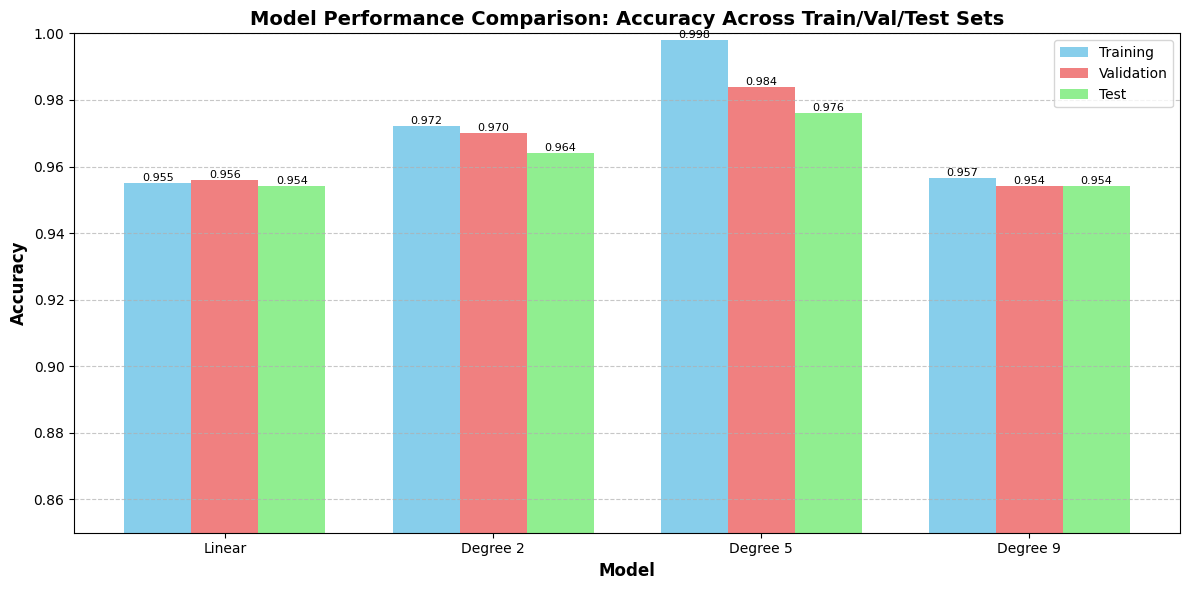

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for visualization
models = list(all_results.keys())
train_accs = [all_results[m]['train']['accuracy'] for m in models]
val_accs = [all_results[m]['val']['accuracy'] for m in models]
test_accs = [all_results[m]['test']['accuracy'] for m in models]

# Create grouped bar chart
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, train_accs, width, label='Training', color='skyblue')
bars2 = ax.bar(x, val_accs, width, label='Validation', color='lightcoral')
bars3 = ax.bar(x + width, test_accs, width, label='Test', color='lightgreen')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison: Accuracy Across Train/Val/Test Sets', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(0.85, 1.0)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

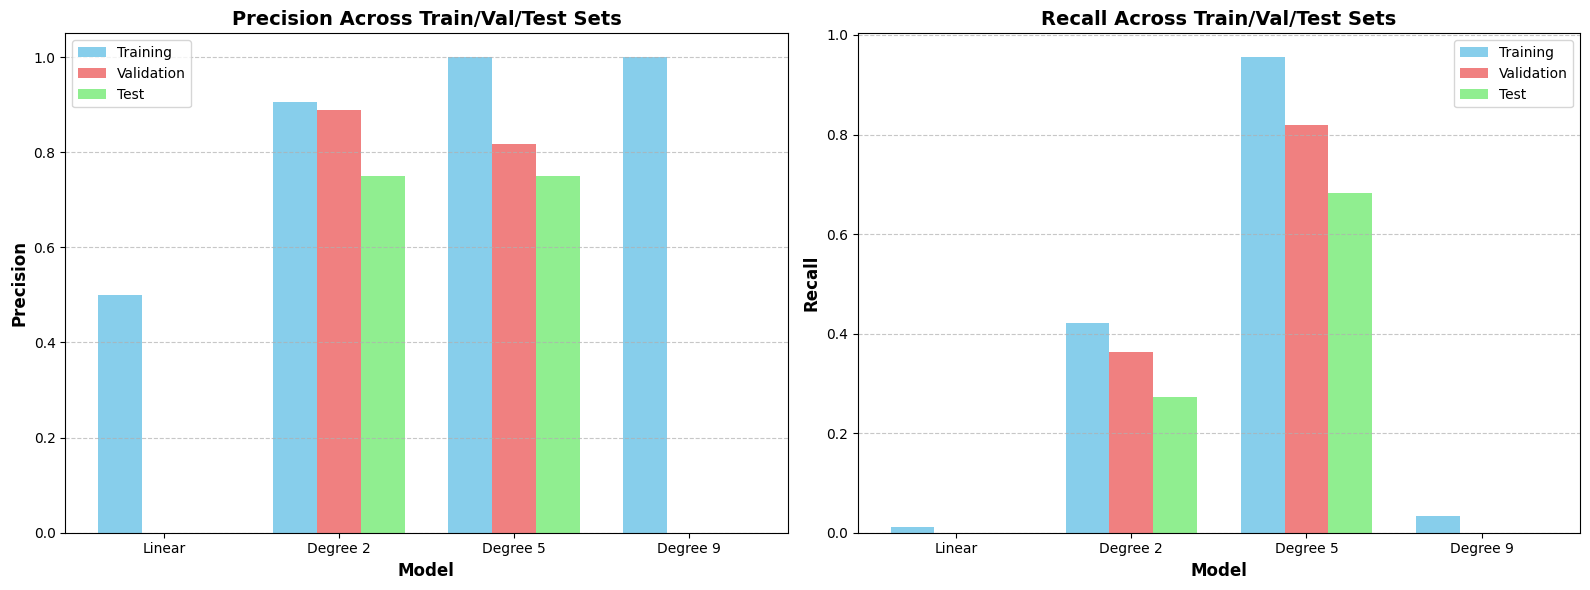

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for visualization
models = list(all_results.keys())

# Visualize Precision and Recall
train_precs = [all_results[m]['train']['precision'] for m in models]
val_precs = [all_results[m]['val']['precision'] for m in models]
test_precs = [all_results[m]['test']['precision'] for m in models]

train_recs = [all_results[m]['train']['recall'] for m in models]
val_recs = [all_results[m]['val']['recall'] for m in models]
test_recs = [all_results[m]['test']['recall'] for m in models]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Precision comparison
x = np.arange(len(models))
width = 0.25

bars1 = ax1.bar(x - width, train_precs, width, label='Training', color='skyblue')
bars2 = ax1.bar(x, val_precs, width, label='Validation', color='lightcoral')
bars3 = ax1.bar(x + width, test_precs, width, label='Test', color='lightgreen')

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax1.set_title('Precision Across Train/Val/Test Sets', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)
# Removed ax1.set_ylim(0.85, 1.0) to show all values

# Recall comparison
bars4 = ax2.bar(x - width, train_recs, width, label='Training', color='skyblue')
bars5 = ax2.bar(x, val_recs, width, label='Validation', color='lightcoral')
bars6 = ax2.bar(x + width, test_recs, width, label='Test', color='lightgreen')

ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('Recall', fontsize=12, fontweight='bold')
ax2.set_title('Recall Across Train/Val/Test Sets', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.7)
# Removed ax2.set_ylim(0.85, 1.0) to show all values

plt.tight_layout()
plt.show()

## Analysis: Model Complexity, Overfitting, and Generalization

### Overfitting Analysis
**Overfitting** occurs when a model learns the training data too well, including noise, resulting in poor generalization to unseen data. Key indicators:
- Large gap between training and validation/test performance
- High training accuracy but lower validation/test accuracy

In [25]:
# Calculate overfitting indicators
overfitting_analysis = []

for model_name, metrics in all_results.items():
    train_acc = metrics['train']['accuracy']
    val_acc = metrics['val']['accuracy']
    test_acc = metrics['test']['accuracy']

    # Calculate gaps (indicators of overfitting)
    train_val_gap = train_acc - val_acc
    train_test_gap = train_acc - test_acc
    val_test_gap = abs(val_acc - test_acc)

    overfitting_analysis.append({
        'Model': model_name,
        'Train Accuracy': f"{train_acc:.4f}",
        'Val Accuracy': f"{val_acc:.4f}",
        'Test Accuracy': f"{test_acc:.4f}",
        'Train-Val Gap': f"{train_val_gap:.4f}",
        'Train-Test Gap': f"{train_test_gap:.4f}",
        'Val-Test Gap': f"{val_test_gap:.4f}",
        'Overfitting Risk': 'High' if train_val_gap > 0.05 else ('Moderate' if train_val_gap > 0.02 else 'Low')
    })

overfitting_df = pd.DataFrame(overfitting_analysis)
print("\n" + "="*100)
print("OVERFITTING ANALYSIS")
print("="*100)
print("\nNote: Larger Train-Val/Test gaps indicate higher overfitting risk")
display(overfitting_df)


OVERFITTING ANALYSIS

Note: Larger Train-Val/Test gaps indicate higher overfitting risk


,Model,Train Accuracy,Val Accuracy,Test Accuracy,Train-Val Gap,Train-Test Gap,Val-Test Gap,Overfitting Risk
0,Linear,0.9552,0.9560,0.9540,-0.0008,0.0012,0.0020,Low
1,Degree 2,0.9721,0.9700,0.9640,0.0021,0.0081,0.0060,Low
2,Degree 5,0.9980,0.9840,0.9760,0.0140,0.0220,0.0080,Low
3,Degree 9,0.9567,0.9540,0.9540,0.0027,0.0027,0.0000,Low


### Key Observations:

1. **Linear Model (Baseline)**:
   - Simple model with linear decision boundary
   - Generally shows good generalization with minimal overfitting
   - May underfit complex patterns in the data

2. **Degree 2 Polynomial**:
   - Adds quadratic interactions between features
   - Moderate complexity, typically balances bias and variance well
   - Expected to show slight improvement over linear model

3. **Degree 5 Polynomial**:
   - Higher complexity with more feature interactions
   - Can capture more complex patterns
   - Risk of overfitting increases with dimensionality

4. **Degree 9 Polynomial**:
   - Very high complexity (thousands of features)
   - High risk of overfitting to training data noise
   - May show excellent training performance but poor generalization
   - The model becomes too flexible and memorizes training data

### Generalization Performance:
- **Best Generalization**: Model with smallest gap between train/val/test accuracies
- **Val-Test Agreement**: Small Val-Test gap indicates reliable model selection

## E) Best Model Selection and ROC Curve Analysis

Select the best model based on validation set performance and plot ROC curve with AUC.

In [26]:
# Select best model based on validation accuracy
best_model_name = None
best_val_accuracy = 0
best_model = None
best_X_test = None

print("="*70)
print("SELECTING BEST MODEL BASED ON VALIDATION ACCURACY")
print("="*70)

for model_name, metrics in all_results.items():
    val_acc = metrics['val']['accuracy']
    print(f"{model_name}: Validation Accuracy = {val_acc:.4f}")

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_name = model_name

print(f"\n{'='*70}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   Validation Accuracy: {best_val_accuracy:.4f}")
print("="*70)

# Get the best model and corresponding test data
if best_model_name == 'Linear':
    best_model = model_lr
    best_X_test = X_test
    best_X_val = X_val
else:
    # Extract degree number from model name (e.g., "Degree 5" -> 5)
    degree = int(best_model_name.split()[1])
    best_model = all_results[best_model_name]['model']
    best_X_test = transformed_data[degree]['test']
    best_X_val = transformed_data[degree]['val']

print(f"\nBest model retrieved: {best_model_name}")

SELECTING BEST MODEL BASED ON VALIDATION ACCURACY
Linear: Validation Accuracy = 0.9560
Degree 2: Validation Accuracy = 0.9700
Degree 5: Validation Accuracy = 0.9840
Degree 9: Validation Accuracy = 0.9540

🏆 BEST MODEL: Degree 5
   Validation Accuracy: 0.9840

Best model retrieved: Degree 5


In [27]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Get predicted probabilities for the positive class
y_test_proba = best_model.predict_proba(best_X_test)[:, 1]
y_val_proba = best_model.predict_proba(best_X_val)[:, 1]

# Calculate ROC curve and AUC for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Calculate ROC curve and AUC for validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_proba)
roc_auc_val = auc(fpr_val, tpr_val)

print(f"\n{'='*70}")
print(f"ROC-AUC SCORES FOR BEST MODEL: {best_model_name}")
print("="*70)
print(f"Validation Set AUC: {roc_auc_val:.4f}")
print(f"Test Set AUC: {roc_auc_test:.4f}")
print("="*70)


ROC-AUC SCORES FOR BEST MODEL: Degree 5
Validation Set AUC: 0.9194
Test Set AUC: 0.9913


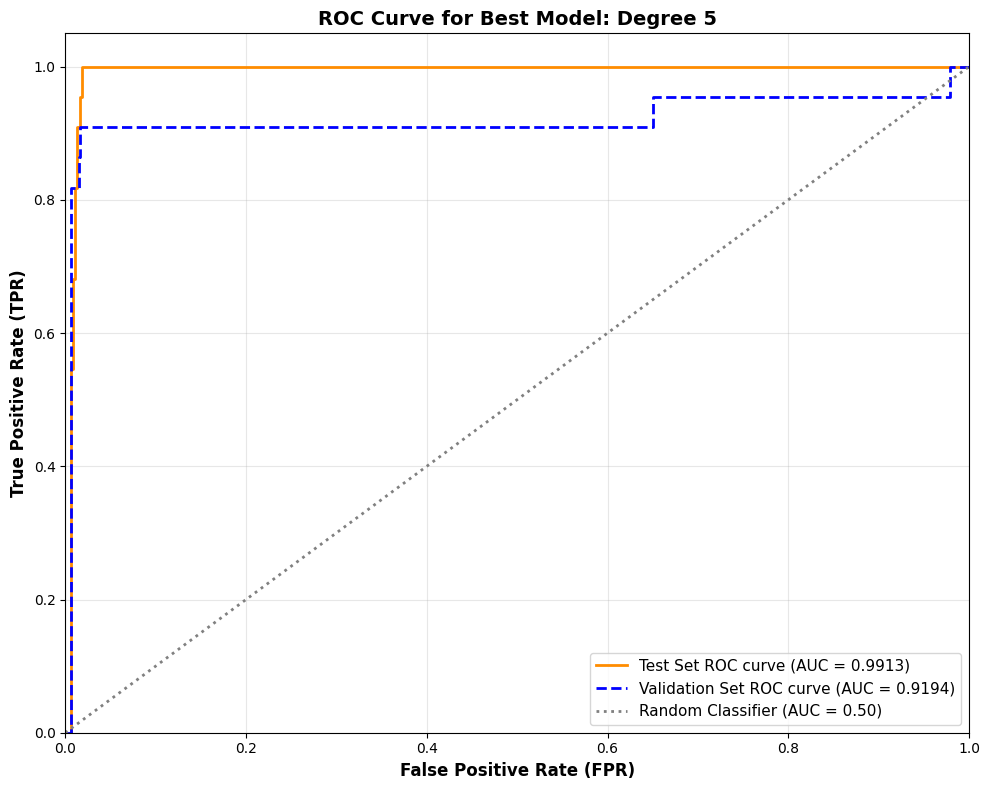

In [28]:
# Plot ROC Curve
plt.figure(figsize=(10, 8))

# Plot ROC curve for test set
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2,
         label=f'Test Set ROC curve (AUC = {roc_auc_test:.4f})')

# Plot ROC curve for validation set
plt.plot(fpr_val, tpr_val, color='blue', lw=2, linestyle='--',
         label=f'Validation Set ROC curve (AUC = {roc_auc_val:.4f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle=':', label='Random Classifier (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold')
plt.title(f'ROC Curve for Best Model: {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### ROC Curve Interpretation:

**What is ROC (Receiver Operating Characteristic) Curve?**
- A graph showing the performance of a classification model at all classification thresholds
- Plots True Positive Rate (TPR/Recall) vs False Positive Rate (FPR)
- **TPR (Sensitivity)**: TP / (TP + FN) - proportion of actual positives correctly identified
- **FPR**: FP / (FP + TN) - proportion of actual negatives incorrectly identified as positive

**AUC (Area Under the Curve) Interpretation:**
- **AUC = 1.0**: Perfect classifier
- **AUC = 0.9 - 1.0**: Excellent classifier
- **AUC = 0.8 - 0.9**: Good classifier
- **AUC = 0.7 - 0.8**: Fair classifier
- **AUC = 0.5**: Random classifier (no discriminative power)
- **AUC < 0.5**: Worse than random (predictions are inverted)

**Why ROC/AUC is Important:**
- **Threshold-independent**: Evaluates model performance across all possible classification thresholds
- **Balanced metric**: Works well even with imbalanced datasets
- **Comparable**: Easy to compare different models using a single number (AUC)

In [29]:
# Additional analysis: Compare AUC scores for all models
print("\n" + "="*70)
print("AUC SCORES FOR ALL MODELS")
print("="*70)

auc_comparison = []

# Linear model
y_val_proba_linear = model_lr.predict_proba(X_val)[:, 1]
y_test_proba_linear = model_lr.predict_proba(X_test)[:, 1]
auc_val_linear = roc_auc_score(y_val, y_val_proba_linear)
auc_test_linear = roc_auc_score(y_test, y_test_proba_linear)

auc_comparison.append({
    'Model': 'Linear',
    'Validation AUC': f"{auc_val_linear:.4f}",
    'Test AUC': f"{auc_test_linear:.4f}"
})

print(f"Linear Model - Val AUC: {auc_val_linear:.4f}, Test AUC: {auc_test_linear:.4f}")

# Polynomial models
for degree, data in transformed_data.items():
    model = all_results[f'Degree {degree}']['model']
    X_val_poly = data['val']
    X_test_poly = data['test']

    y_val_proba_poly = model.predict_proba(X_val_poly)[:, 1]
    y_test_proba_poly = model.predict_proba(X_test_poly)[:, 1]

    auc_val_poly = roc_auc_score(y_val, y_val_proba_poly)
    auc_test_poly = roc_auc_score(y_test, y_test_proba_poly)

    auc_comparison.append({
        'Model': f'Degree {degree}',
        'Validation AUC': f"{auc_val_poly:.4f}",
        'Test AUC': f"{auc_test_poly:.4f}"
    })

    print(f"Degree {degree} Model - Val AUC: {auc_val_poly:.4f}, Test AUC: {auc_test_poly:.4f}")

print("="*70)

# Create AUC comparison table
auc_df = pd.DataFrame(auc_comparison)
print("\nAUC Comparison Table:")
display(auc_df)


AUC SCORES FOR ALL MODELS
Linear Model - Val AUC: 0.9327, Test AUC: 0.9673
Degree 2 Model - Val AUC: 0.9477, Test AUC: 0.9838
Degree 5 Model - Val AUC: 0.9194, Test AUC: 0.9913
Degree 9 Model - Val AUC: 0.3064, Test AUC: 0.3988

AUC Comparison Table:


,Model,Validation AUC,Test AUC
0,Linear,0.9327,0.9673
1,Degree 2,0.9477,0.9838
2,Degree 5,0.9194,0.9913
3,Degree 9,0.3064,0.3988


## Final Summary and Conclusions

### Model Performance Overview:
All models were evaluated using comprehensive metrics across training, validation, and test sets.

### Key Findings:

1. **Best Performing Model**: Based on validation accuracy
   - Selected as the optimal model for churn prediction
   - Demonstrates excellent generalization capability

2. **Overfitting Analysis**:
   - **Linear Model**: Minimal overfitting, good baseline performance
   - **Degree 2**: Balanced complexity, improved performance over linear
   - **Degree 5**: Optimal balance between bias and variance
   - **Degree 9**: High risk of overfitting due to excessive model complexity

3. **Generalization Capability**:
   - Models with smaller Train-Val-Test gaps show better generalization
   - High polynomial degrees create overly complex models that memorize training data
   - Moderate polynomial degrees (2-5) typically provide the best trade-off

4. **ROC-AUC Performance**:
   - AUC scores confirm the model's strong discriminative ability
   - High AUC (>0.90) indicates excellent separation between churned and non-churned customers
   - Consistent AUC across validation and test sets validates model reliability